In [13]:
import numpy as np
import pandas as pd
from tensorly.decomposition import  partial_tucker,parafac2
import tensorly as tl
from tensorly.parafac2_tensor import parafac2_to_slice, apply_parafac2_projections
from tfac.Data_Mod import form_tensor
from tfac.tensor import partial_tucker_decomp, find_R2X_partialtucker, flip_factors
from pseudoinvnorm import get_Flattened_Matrices, get_reconstruct
from pybiomart import Server
import gseapy as gp
import copy
import matplotlib.pyplot as plt 
tl.set_backend("numpy")
#decompse the tensor
# component = 5
# tensor, treatment_list, times = form_tensor()
# pre_flip_result = partial_tucker_decomp(tensor, [2], component)
# result = flip_factors(pre_flip_result)
#load the gene expression data
geneexpression = pd.read_csv("tfac/data/ohsu/MDD_RNAseq_Level4.csv")
ids = geneexpression["ensembl_gene_id"]
# P, X = get_Flattened_Matrices(result, geneexpression, treatment_list, times)
# Ppinv, W = get_reconstruct(P,X)
df = pd.DataFrame(geneexpression)

In [2]:
def find_unique(df):
    "For given component prerank results, determines for each geneset how many components have larger positive/negative magnitude NES"
    largepos = []
    largeneg = []
    for geneset in df.index:
        counti = 0
        countn = 0
        if geneset in alls.index:
            for comp in alls.loc[geneset]:
                if comp > 1 * df.loc[geneset][1] and df.loc[geneset][1] > 0:
                    counti += 1
                if comp < -1 * df.loc[geneset][1] and df.loc[geneset][1] > 0:
                    countn += 1
                if comp < 1 * df.loc[geneset][1] and df.loc[geneset][1] < 0:
                    countn += 1
                if comp > -1 * df.loc[geneset][1] and df.loc[geneset][1] < 0:
                    counti += 1
        largepos.append(counti)
        largeneg.append(countn)
    df["largepos"] = largepos
    df["largeneg"] = largeneg
    
def ensembl_convert(df, geneids, decimals):
    convtable = pd.DataFrame()
    server = Server(host='http://www.ensembl.org')
    dataset = (server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl'])
    convtable = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])
    ourids = copy.deepcopy(geneids)
    if(decimals):
        for a in range(len(ourids)):
            ourids[a] = ourids[a][:ourids[a].index(".") ]
            
    
    newnames = []
    newtens = pd.DataFrame(df)
    newtens["ensembl ids"] = ourids
    droppedids = newtens[~newtens["ensembl ids"].isin(convtable["Gene stable ID"])]
    newtens = newtens[newtens["ensembl ids"].isin(convtable["Gene stable ID"])]
    for ensid in newtens["ensembl ids"]:
        table = convtable[convtable["Gene stable ID"] == ensid]
        table.reset_index(inplace = True)
        newnames.append(table.at[0, "Gene name"])

    newtens["Gene ID"] = newnames
    
    return newtens

def gsea(newtens, component, lib):
    prtens = pd.concat((newtens["Gene ID"], newtens[newtens.columns[component]]), axis = 1)
    pre_res = gp.prerank(rnk=prtens, gene_sets=lib, processes=4, max_size=500, permutation_num=100, weighted_score_type=1.5, outdir=None, format='png', seed=6)
    return pre_res.res2d.sort_index()

# df = ensembl_convert(df, ids, False)

KeyboardInterrupt: 

In [3]:


# lib_list = ['GO_Biological_Process_2018','GO_Cellular_Component_2018','GO_Molecular_Function_2018','KEGG_2019_Human','BioPlanet_2019', 'Genes_Associated_with_NIH_Grants']
# # other_list = ['OSM_48', 'IFNG_48']
# other_list = [7, -5]
# ret = []
# for lib in lib_list:
#     add = []
#     for i in other_list:
#         to_add = gsea(df,i,lib)
#         add.append(to_add)
#     ret.append(add)

2021-03-04 12:20:39,879 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2021-03-04 12:26:57,695 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2021-03-04 12:33:22,450 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2021-03-04 12:34:08,623 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2021-03-04 12:34:54,770 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2021-03-04 12:36:22,013 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2021-03-04 12:37:49,538 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2021-03-04 12:38:40,603 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2021-03-04 12:39:31,890 Input gene rankings contains duplicated IDs, Onl

In [7]:
# count = 0
# for a in ret:
#     for b in a:
#         b.to_pickle("fold_dfs/" + str(count) + ".pkl")
#         count +=1

In [4]:
filtered=[]
t_set=[]
for i in range(12):
    t_set.append(pd.read_pickle('fold_dfs/'+str(i)+'.pkl'))
    if ((i+1)%2==0):
        filtered.append(t_set)
        t_set = []

In [5]:
#all enriched gene sets for component 2
tot2 = pd.DataFrame()
for i in range(6):
    tot2 = pd.concat([tot2, filtered[i][1]])

#all enriched gene sets for component 1
tot1 = pd.DataFrame()
for i in range(6):
    tot1 = pd.concat([tot1, filtered[i][0]])

# #all enriched gene sets
# tot = pd.DataFrame()
# for i in range(6):
#     for j in range(5):
#         tot = pd.concat([tot, filtered[i][j]])




heat1 = tot1.copy().reset_index()
heat2 = tot2.copy().reset_index()


heat1 = heat1[["Term", "es"]]
heat2 = heat2[["Term", "es"]]


all_tots = [heat1, heat2]


for m_df in all_tots:
    for row,cols in m_df.iterrows():
        if cols["Term"] not in list(heat1["Term"]):
            heat1 = heat1.append({"Term":cols["Term"], "es":0}, ignore_index = True)
        if cols["Term"] not in list(heat2["Term"]):
            heat2 = heat2.append({"Term":cols["Term"], "es":0}, ignore_index = True)

heat1.drop_duplicates(subset=['Term'], inplace = True)
heat2.drop_duplicates(subset=['Term'], inplace = True)


heat1.sort_values(by=['Term'], inplace = True)
heat2.sort_values(by=['Term'], inplace = True)

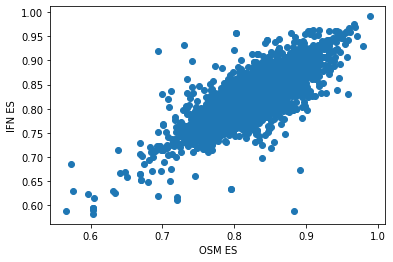

In [15]:
plt.scatter(heat1["es"], heat2['es'])
plt.xlabel("OSM ES") 
plt.ylabel("IFN ES") 
plt.show() 